In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import sys

import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.model_selection import KFold
from ml_metrics import rmsle

import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_hdf('../input/clean_database.realestate.h5')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19144 entries, 0 to 0
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   parking                                6854 non-null   object 
 1   surroundings                           19144 non-null  object 
 2   extra_description                      16732 non-null  object 
 3   benefit_investment                     1383 non-null   object 
 4   broker_license                         19144 non-null  object 
 5   broker_id                              19144 non-null  int16  
 6   broker_company_id                      19144 non-null  int16  
 7   building_num_floor                     19144 non-null  int64  
 8   type_building                          19144 non-null  object 
 9   year_building                          19144 non-null  int64  
 10  material_building                      19144 non-null  object 
 11  benefi

In [4]:
print (train[ train.price.isnull() ].shape)
print (train[ train.price == -1 ].shape)

(268, 50)
(1748, 50)


In [5]:
train = train[ False == train.price.isnull() ]
train = train[ train.price != -1 ]
train.shape

(17128, 50)

<Figure size 36000x1440 with 0 Axes>

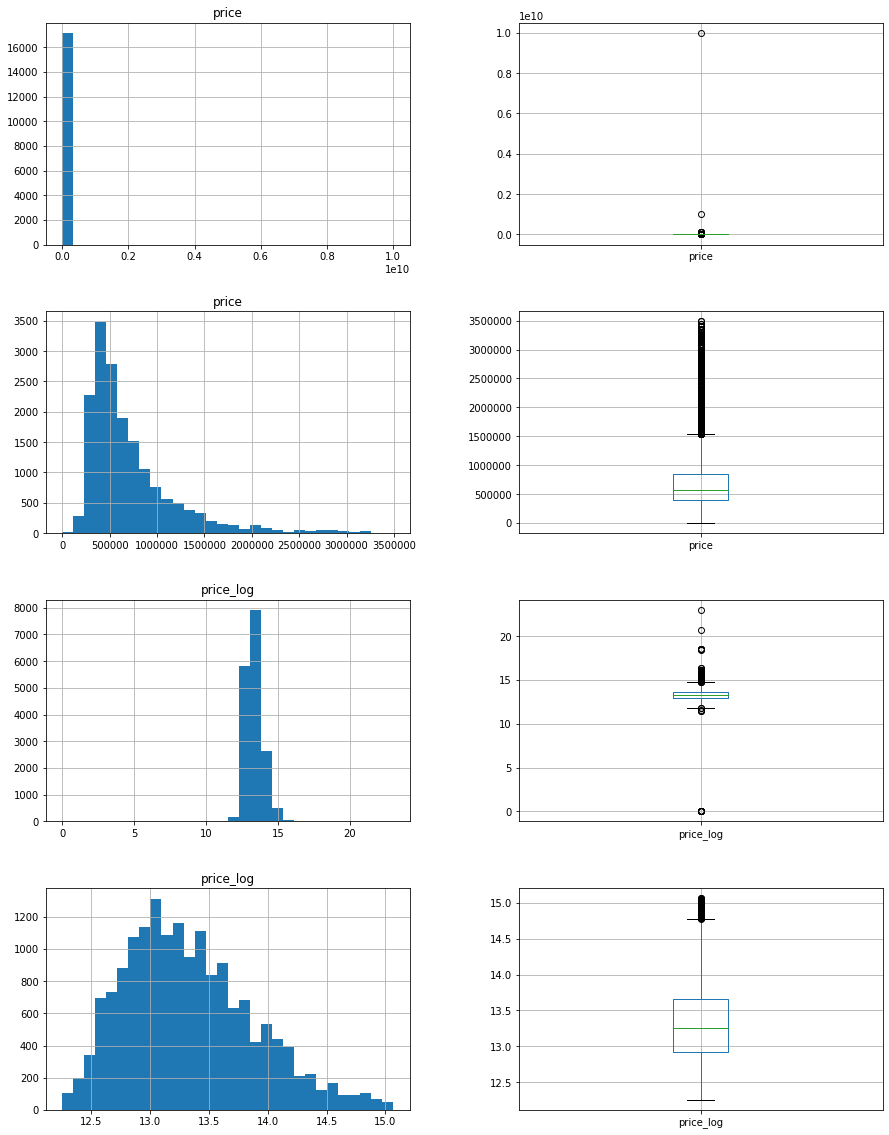

In [6]:
train['price_log'] = np.log( train['price'] )

plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 20))
fig.subplots_adjust(hspace=.8)

def sub_plot(data, column, ax1, ax2):
    data.hist(column, bins=30, ax=ax1)
    data.boxplot(column, ax=ax2)

sub_plot(train, 'price', ax1, ax2)
sub_plot(train[ train.price < np.percentile( train.price, 99 ) ], 'price', ax3, ax4)
sub_plot(train, 'price_log', ax5, ax6)
sub_plot(train[ (train.price_log > np.percentile( train.price_log, 1 )) & (train.price_log < np.percentile( train.price_log, 99 )) ], 'price_log', ax7, ax8)

In [7]:
X = train[ ['year_building'] ].values
y = train['price'].values

model = DummyRegressor()

cv = KFold(n_splits=4)

scores = []
for train_idx, test_idx in cv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = rmsle(y_test, y_pred)
    scores.append( score )
    
    
print(np.mean(scores), np.std(scores))

1.068303572845021 0.24185272714742417


In [16]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int, np.float]).columns 
    return feats[ (feats != 'price') & (feats != 'price_log') ].values

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='price'):
    return df[target_var].values

def get_models():
    return [
        ('dummy_mean', DummyRegressor(strategy='mean')),
        ('dummy_median', DummyRegressor(strategy='median'))
        
        
    ]

def run_cv(model, X, y, folds=4, target_log=False,cv_type=KFold, success_metric=rmsle):
    cv = cv_type(n_splits=folds)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
            y_pred[y_pred < 0] = 0 

        score = success_metric(y_test, y_pred)
        scores.append( score )
        
    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        if target_log:
            y = np.exp(y)
            y_pred = np.exp(y_pred)
            y_pred[ y_pred<0 ] = 0
        
        return rmsle(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run(train, plot_lc=False, folds=3, ylim=(0, 2), target_log=False):
    X, y  = get_X(train), get_y(train)

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds, target_log=target_log)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() 

        if False == plot_lc: continue
        plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log)
        plt.show()

In [17]:
X,y = get_X(train), get_y(train)

for model_name, model in get_models():
    score_mean, score_std = run_cv(model, X, y)
    print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))

[dummy_mean]: 1.068303572845021 +/-0.24185272714742417
[dummy_median]: 0.6647178069578086 +/-0.084824428222137


[dummy_mean]: 1.0691539140857458 +/-0.2799221428810655


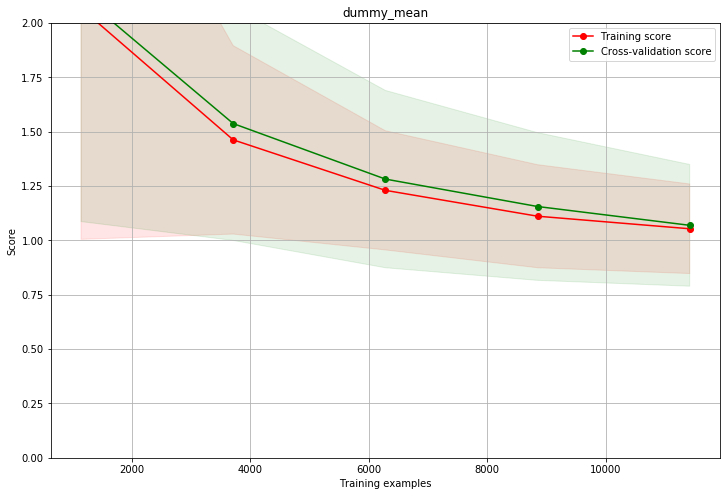

[dummy_median]: 0.6678517039942227 +/-0.06464186349579217


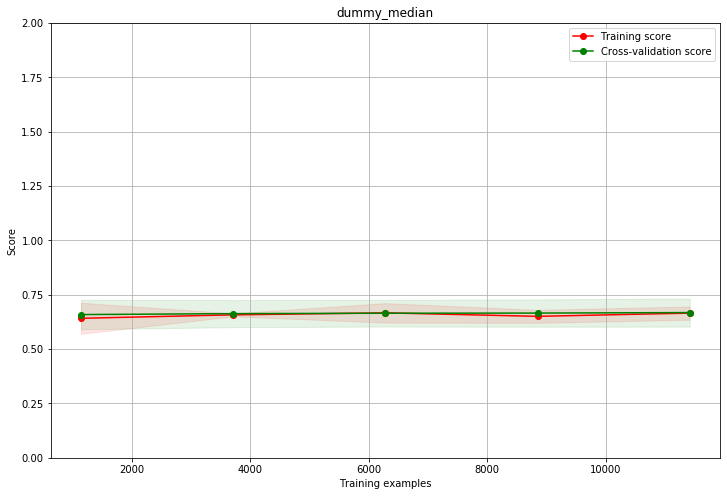

[dt-5md]: 0.49498833829263855 +/-0.07353893217629608


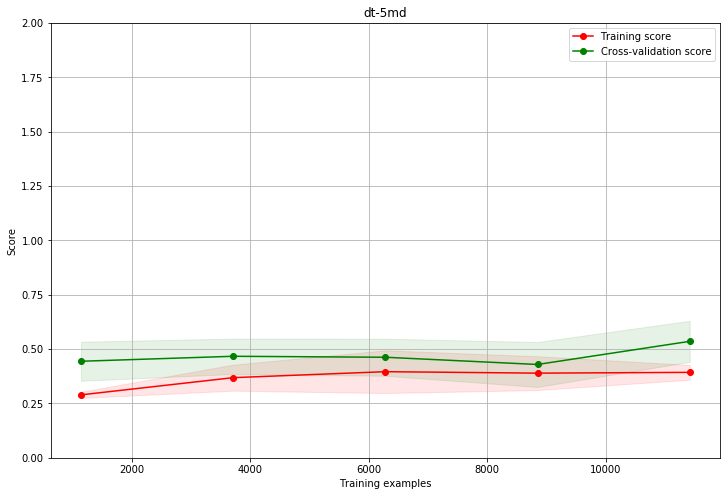

In [12]:
def get_models():
    return [
        ('dummy_mean', DummyRegressor(strategy='mean')),
        ('dummy_median', DummyRegressor(strategy='median')),
        ('dt-5md', DecisionTreeRegressor(max_depth=5)),
    ]

run(train, plot_lc=True)